In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle


In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    my_seed = 42,
                    TIME = 8,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on
                  ):
    # 함수 내 모든 로컬 변수 저장
    hyperparameters = locals()
    hyperparameters['top_train_acc_one_iter'] = 0
    hyperparameters['top_val_acc'] = 0
    hyperparameters['current epoch'] = 0

    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices

    
    torch.manual_seed(my_seed)


    
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on)
    synapse_fc_out_features = CLASS_NUM


    ## parameter number calculator ##########################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ## parameter number calculator ##########################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net)
    else:
        net = torch.load(pre_trained_path)


    net = net.to(device)
    if (net_print == True):
        print(net)
    
    ## param num and memory estimation except BN at MY calculation ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##########################################################################

    criterion = nn.CrossEntropyLoss().to(device)
    
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler

    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    train_acc_array = np.array([])
    val_acc_now_array = np.array([])
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        if (domain_il_epoch>0 and which_data == 'PMNIST'):
            k = epoch // domain_il_epoch
            xtrain=data[k]['train']['x']
            ytrain=data[k]['train']['y']
            xtest =data[k]['test']['x']
            ytest =data[k]['test']['y']

        
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)

        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train()

            ## data loading #################################
            inputs, labels = data

            
            if (which_data == 'DVS_CIFAR10'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ################################################# 

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width]   
            # print(inputs.size())
            outputs = net(inputs)

            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)

            


            ####### training accruacy print ###############################
            correct = 0
            total = 0
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted[0:batch] == labels).sum().item()
            train_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * train_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            training_acc_string = f'{epoch}-{i}/{len(train_loader)} tr_acc: {100 * correct / total:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()


            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            
            optimizer.step()

            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##############################################
            if i % validation_interval == validation_interval-1:
                iter_one_val_time_start = time.time()
                
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval()
                    for data in test_loader:
                        ## data loading #################################
                        inputs, labels = data

                        
                        if (which_data == 'DVS_CIFAR10'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ################################################# 

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), "net_save/save_now_net_weights.pth")
                    torch.save(net, "net_save/save_now_net.pth")
                    torch.save(net.module.state_dict(), "net_save/save_now_net_weights2.pth")
                    torch.save(net.module, "net_save/save_now_net2.pth")
            ################################################################
            iterator.set_description(f"train: {training_acc_string}, tr_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  

            train_acc_array = np.append(train_acc_array, train_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
            val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
            hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

            if(train_acc > hyperparameters['top_train_acc_one_iter']):
                hyperparameters['top_train_acc_one_iter'] = train_acc
            if(val_acc_now > hyperparameters['top_val_acc']):
                hyperparameters['top_val_acc'] = val_acc_now
            hyperparameters['current epoch'] = epoch

            # 덮어쓰기 하기 싫으면 주석 풀어서 사용
            # np.save(train_acc_file_name, train_acc_array)
            # np.save(val_acc_file_name, val_acc_now_array)
            # with open(hyperparameters_file_name, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)

            np.save('result_save/train_acc_array.npy', train_acc_array)
            np.save('result_save/val_acc_now_array.npy', val_acc_now_array)
            with open('result_save/hyperparameters.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
            
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        
        
        epoch_time_end = time.time()
        epoch_time = epoch_time_end - epoch_start_time  # 실행 시간 계산
        
        print(f"epoch_time: {epoch_time} seconds")
        print('\n')


In [5]:
### my_snn control board ########################
decay = 0.25 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

my_snn_system(  devices = "0,1,2,3,4,5",
                my_seed = 42,
                TIME = 10, # dvscifar 10 # ottt 6 or 10 # nda 10
                BATCH = 256, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 48, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_CIFAR10',# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = True, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 10000.5, #nda 0.5  #ottt 1.0 # 10000이상으로 하면 NDA LIF 씀.
                lif_layer_v_reset = 0.0, #현재 안씀. 걍 빼기 해버림
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # 10000 이상은 separable, 20000이상은 depthwise
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [64], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                pre_trained_path = "net_save/save_now_net.pth",
                learning_rate = 0.001, # default 0.001  # ottt 0.1  # nda 0.001
                epoch_num = 200,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐
                validation_interval = 36, #숫자 크게 하면 꺼짐
                tdBN_on = True,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'rough_rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = True,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'Adam', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling이 낫다.

# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


DataParallel(
  (module): MY_SNN_CONV(
    (layers): Sequential(
      (0): SYNAPSE_CONV_BPTT()
      (1): tdBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): DimChanger_for_change_0_1()
      (3): LIFSpike()
      (4): DimChanger_for_change_0_1()
      (5): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (6): SYNAPSE_CONV_BPTT()
      (7): tdBatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): DimChanger_for_change_0_1()
      (9): LIFSpike()
      (10): DimChanger_for_change_0_1()
      (11): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (12): SYNAPSE_CONV_BPTT()
      (13): tdBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): DimChanger_for_change_0_1()
      (15): LIFSpike()
      (16): DimChanger_for_change_0_1()
      (17): SYNAPSE_CONV_BPTT()
      

train: 0-35/36 tr_acc: 50.00%, lr=['0.001'], tr_loss: 1.7448835372924805, val_acc: 18.60%: 100%|██████████| 36/36 [00:32<00:00,  1.10it/s]

epoch_time: 33.01463031768799 seconds


EPOCH 1



train: 1-35/36 tr_acc: 22.50%, lr=['0.0009999383162408303'], tr_loss: 1.9015610218048096, val_acc: 38.80%: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]

epoch_time: 17.508930921554565 seconds


EPOCH 2



train: 2-35/36 tr_acc: 32.50%, lr=['0.0009997532801828658'], tr_loss: 1.8473803997039795, val_acc: 40.70%: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]

epoch_time: 17.590172290802002 seconds


EPOCH 3



train: 3-35/36 tr_acc: 35.00%, lr=['0.0009994449374809851'], tr_loss: 1.6904878616333008, val_acc: 34.50%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.0308358669281 seconds


EPOCH 4



train: 4-35/36 tr_acc: 45.00%, lr=['0.0009990133642141358'], tr_loss: 1.5952754020690918, val_acc: 37.90%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.021836042404175 seconds


EPOCH 5



train: 5-35/36 tr_acc: 45.00%, lr=['0.000998458666866564'], tr_loss: 1.6466624736785889, val_acc: 28.50%: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s]

epoch_time: 16.799312114715576 seconds


EPOCH 6



train: 6-35/36 tr_acc: 32.50%, lr=['0.00099778098230154'], tr_loss: 1.5789828300476074, val_acc: 32.20%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]

epoch_time: 17.085639238357544 seconds


EPOCH 7



train: 7-35/36 tr_acc: 37.50%, lr=['0.0009969804777275899'], tr_loss: 1.7620823383331299, val_acc: 46.50%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s]

epoch_time: 17.766266584396362 seconds


EPOCH 8



train: 8-35/36 tr_acc: 42.50%, lr=['0.000996057350657239'], tr_loss: 1.3882520198822021, val_acc: 34.00%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.05139398574829 seconds


EPOCH 9



train: 9-35/36 tr_acc: 70.00%, lr=['0.0009950118288582787'], tr_loss: 1.1050375699996948, val_acc: 43.30%: 100%|██████████| 36/36 [00:16<00:00,  2.19it/s]

epoch_time: 16.741663455963135 seconds


EPOCH 10



train: 10-35/36 tr_acc: 50.00%, lr=['0.0009938441702975688'], tr_loss: 1.4273277521133423, val_acc: 38.10%: 100%|██████████| 36/36 [00:16<00:00,  2.12it/s]

epoch_time: 17.198158502578735 seconds


EPOCH 11



train: 11-35/36 tr_acc: 55.00%, lr=['0.000992554663077387'], tr_loss: 1.237242579460144, val_acc: 45.70%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 


epoch_time: 17.014130115509033 seconds


EPOCH 12


train: 12-35/36 tr_acc: 50.00%, lr=['0.0009911436253643444'], tr_loss: 1.2413644790649414, val_acc: 48.70%: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]

epoch_time: 17.43258833885193 seconds


EPOCH 13



train: 13-35/36 tr_acc: 50.00%, lr=['0.0009896114053108828'], tr_loss: 1.4394137859344482, val_acc: 43.50%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]

epoch_time: 16.96540880203247 seconds


EPOCH 14



train: 14-35/36 tr_acc: 55.00%, lr=['0.0009879583809693736'], tr_loss: 1.3709485530853271, val_acc: 43.50%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]

epoch_time: 17.12652826309204 seconds


EPOCH 15



train: 15-35/36 tr_acc: 65.00%, lr=['0.0009861849601988382'], tr_loss: 1.0136417150497437, val_acc: 29.40%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]

epoch_time: 16.958970546722412 seconds


EPOCH 16



train: 16-35/36 tr_acc: 65.00%, lr=['0.0009842915805643154'], tr_loss: 1.2289106845855713, val_acc: 51.80%: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]


epoch_time: 17.379066705703735 seconds


EPOCH 17


train: 17-35/36 tr_acc: 52.50%, lr=['0.000982278709228899'], tr_loss: 1.1609714031219482, val_acc: 49.70%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]


epoch_time: 17.15681791305542 seconds


EPOCH 18


train: 18-35/36 tr_acc: 55.00%, lr=['0.0009801468428384714'], tr_loss: 1.1034114360809326, val_acc: 53.90%: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]

epoch_time: 17.39665174484253 seconds


EPOCH 19



train: 19-35/36 tr_acc: 47.50%, lr=['0.0009778965073991648'], tr_loss: 1.376191258430481, val_acc: 48.70%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s] 

epoch_time: 16.855749368667603 seconds


EPOCH 20



train: 20-35/36 tr_acc: 70.00%, lr=['0.0009755282581475766'], tr_loss: 0.775865912437439, val_acc: 37.60%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.05288052558899 seconds


EPOCH 21



train: 21-35/36 tr_acc: 65.00%, lr=['0.0009730426794137723'], tr_loss: 1.2157145738601685, val_acc: 44.50%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]

epoch_time: 16.95937943458557 seconds


EPOCH 22



train: 22-35/36 tr_acc: 65.00%, lr=['0.0009704403844771124'], tr_loss: 0.8247405886650085, val_acc: 56.80%: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]

epoch_time: 17.514251470565796 seconds


EPOCH 23



train: 23-35/36 tr_acc: 62.50%, lr=['0.0009677220154149334'], tr_loss: 1.0583144426345825, val_acc: 42.80%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]

epoch_time: 16.965458393096924 seconds


EPOCH 24



train: 24-35/36 tr_acc: 60.00%, lr=['0.0009648882429441253'], tr_loss: 1.1133612394332886, val_acc: 53.50%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]

epoch_time: 17.178861379623413 seconds


EPOCH 25



train: 25-35/36 tr_acc: 80.00%, lr=['0.000961939766255643'], tr_loss: 0.7024981379508972, val_acc: 47.90%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]

epoch_time: 17.104194402694702 seconds


EPOCH 26



train: 26-35/36 tr_acc: 75.00%, lr=['0.0009588773128419901'], tr_loss: 0.7144647836685181, val_acc: 47.10%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.003435611724854 seconds


EPOCH 27



train: 27-35/36 tr_acc: 70.00%, lr=['0.0009557016383177221'], tr_loss: 0.944413959980011, val_acc: 54.60%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s] 

epoch_time: 16.8691668510437 seconds


EPOCH 28



train: 28-35/36 tr_acc: 82.50%, lr=['0.0009524135262330093'], tr_loss: 0.9032400250434875, val_acc: 50.10%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.003223180770874 seconds


EPOCH 29



train: 29-35/36 tr_acc: 67.50%, lr=['0.0009490137878803073'], tr_loss: 0.658704936504364, val_acc: 56.70%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s] 

epoch_time: 17.177208185195923 seconds


EPOCH 30



train: 30-35/36 tr_acc: 60.00%, lr=['0.0009455032620941834'], tr_loss: 0.9703149795532227, val_acc: 54.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 16.997248888015747 seconds


EPOCH 31



train: 31-35/36 tr_acc: 82.50%, lr=['0.0009418828150443463'], tr_loss: 0.5839806795120239, val_acc: 32.50%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.016223430633545 seconds


EPOCH 32



train: 32-35/36 tr_acc: 80.00%, lr=['0.0009381533400219311'], tr_loss: 0.4897397458553314, val_acc: 45.80%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]

epoch_time: 17.076746463775635 seconds


EPOCH 33



train: 33-35/36 tr_acc: 70.00%, lr=['0.0009343157572190951'], tr_loss: 0.8130561113357544, val_acc: 57.50%: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s]

epoch_time: 17.50314712524414 seconds


EPOCH 34



train: 34-35/36 tr_acc: 72.50%, lr=['0.0009303710135019713'], tr_loss: 0.7623000144958496, val_acc: 54.30%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.113133430480957 seconds


EPOCH 35



train: 35-35/36 tr_acc: 80.00%, lr=['0.0009263200821770456'], tr_loss: 0.5220328569412231, val_acc: 56.40%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.10782766342163 seconds


EPOCH 36



train: 36-35/36 tr_acc: 82.50%, lr=['0.000922163962751007'], tr_loss: 0.5722689628601074, val_acc: 53.40%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.066994428634644 seconds


EPOCH 37



train: 37-35/36 tr_acc: 67.50%, lr=['0.0009179036806841347'], tr_loss: 0.7496376633644104, val_acc: 61.60%: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s] 

epoch_time: 17.3994562625885 seconds


EPOCH 38



train: 38-35/36 tr_acc: 77.50%, lr=['0.0009135402871372803'], tr_loss: 0.8697417974472046, val_acc: 54.50%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s] 

epoch_time: 16.905916690826416 seconds


EPOCH 39



train: 39-35/36 tr_acc: 85.00%, lr=['0.0009090748587125112'], tr_loss: 0.5375507473945618, val_acc: 54.50%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.030038833618164 seconds


EPOCH 40



train: 40-35/36 tr_acc: 82.50%, lr=['0.0009045084971874732'], tr_loss: 0.5018976926803589, val_acc: 61.00%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s] 

epoch_time: 17.198947429656982 seconds


EPOCH 41



train: 41-35/36 tr_acc: 77.50%, lr=['0.0008998423292435448'], tr_loss: 0.7245054841041565, val_acc: 55.50%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.06222414970398 seconds


EPOCH 42



train: 42-35/36 tr_acc: 75.00%, lr=['0.0008950775061878446'], tr_loss: 0.7979056239128113, val_acc: 58.60%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.15569519996643 seconds


EPOCH 43



train: 43-35/36 tr_acc: 77.50%, lr=['0.0008902152036691643'], tr_loss: 0.6869518160820007, val_acc: 58.10%: 100%|██████████| 36/36 [00:17<00:00,  2.12it/s] 

epoch_time: 17.289189100265503 seconds


EPOCH 44



train: 44-35/36 tr_acc: 82.50%, lr=['0.000885256621387894'], tr_loss: 0.663411021232605, val_acc: 59.30%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]  

epoch_time: 17.217185974121094 seconds


EPOCH 45



train: 45-35/36 tr_acc: 82.50%, lr=['0.0008802029828000149'], tr_loss: 0.6332871913909912, val_acc: 54.00%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.94304895401001 seconds


EPOCH 46



train: 46-35/36 tr_acc: 92.50%, lr=['0.0008750555348152292'], tr_loss: 0.30653348565101624, val_acc: 65.60%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]

epoch_time: 16.977658987045288 seconds


EPOCH 47



train: 47-35/36 tr_acc: 75.00%, lr=['0.0008698155474893041'], tr_loss: 0.6995401382446289, val_acc: 57.70%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.118690967559814 seconds


EPOCH 48



train: 48-35/36 tr_acc: 82.50%, lr=['0.0008644843137107051'], tr_loss: 0.5966628789901733, val_acc: 62.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.040342807769775 seconds


EPOCH 49



train: 49-35/36 tr_acc: 77.50%, lr=['0.0008590631488815938'], tr_loss: 0.6922938227653503, val_acc: 65.20%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 


epoch_time: 16.94507098197937 seconds


EPOCH 50


train: 50-35/36 tr_acc: 72.50%, lr=['0.0008535533905932731'], tr_loss: 0.8583307266235352, val_acc: 53.70%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.09278964996338 seconds


EPOCH 51



train: 51-35/36 tr_acc: 92.50%, lr=['0.0008479563982961564'], tr_loss: 0.31448429822921753, val_acc: 59.70%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.04416584968567 seconds


EPOCH 52



train: 52-35/36 tr_acc: 82.50%, lr=['0.0008422735529643437'], tr_loss: 0.4277786612510681, val_acc: 62.20%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 16.97557282447815 seconds


EPOCH 53



train: 53-35/36 tr_acc: 77.50%, lr=['0.000836506256754886'], tr_loss: 0.6598827838897705, val_acc: 61.30%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.071784019470215 seconds


EPOCH 54



train: 54-35/36 tr_acc: 85.00%, lr=['0.0008306559326618253'], tr_loss: 0.5989564657211304, val_acc: 58.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.048359870910645 seconds


EPOCH 55



train: 55-35/36 tr_acc: 82.50%, lr=['0.0008247240241650912'], tr_loss: 0.661678671836853, val_acc: 58.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]  

epoch_time: 17.047255754470825 seconds


EPOCH 56



train: 56-35/36 tr_acc: 77.50%, lr=['0.0008187119948743442'], tr_loss: 0.6251571774482727, val_acc: 54.40%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 16.991616249084473 seconds


EPOCH 57



train: 57-35/36 tr_acc: 77.50%, lr=['0.000812621328167852'], tr_loss: 0.5424580574035645, val_acc: 57.80%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.127662897109985 seconds


EPOCH 58



train: 58-35/36 tr_acc: 80.00%, lr=['0.0008064535268264877'], tr_loss: 0.7057796716690063, val_acc: 56.90%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.93062162399292 seconds


EPOCH 59



train: 59-35/36 tr_acc: 82.50%, lr=['0.0008002101126629415'], tr_loss: 0.582909345626831, val_acc: 60.90%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]  

epoch_time: 17.101499795913696 seconds


EPOCH 60



train: 60-35/36 tr_acc: 80.00%, lr=['0.000793892626146236'], tr_loss: 0.4111616611480713, val_acc: 61.90%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.094616651535034 seconds


EPOCH 61



train: 61-35/36 tr_acc: 95.00%, lr=['0.0007875026260216388'], tr_loss: 0.32889577746391296, val_acc: 60.60%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]

epoch_time: 17.048502445220947 seconds


EPOCH 62



train: 62-35/36 tr_acc: 75.00%, lr=['0.0007810416889260649'], tr_loss: 0.6176289916038513, val_acc: 57.30%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s] 


epoch_time: 17.16016936302185 seconds


EPOCH 63


train: 63-35/36 tr_acc: 90.00%, lr=['0.0007745114089990654'], tr_loss: 0.38148313760757446, val_acc: 62.40%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.011061191558838 seconds


EPOCH 64



train: 64-35/36 tr_acc: 92.50%, lr=['0.0007679133974894978'], tr_loss: 0.32150670886039734, val_acc: 62.00%: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]

epoch_time: 17.340949296951294 seconds


EPOCH 65



train: 65-35/36 tr_acc: 92.50%, lr=['0.0007612492823579739'], tr_loss: 0.28334441781044006, val_acc: 64.10%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]

epoch_time: 17.17387890815735 seconds


EPOCH 66



train: 66-35/36 tr_acc: 85.00%, lr=['0.0007545207078751852'], tr_loss: 0.4326642155647278, val_acc: 64.60%: 100%|██████████| 36/36 [00:16<00:00,  2.12it/s] 

epoch_time: 17.23621129989624 seconds


EPOCH 67



train: 67-35/36 tr_acc: 85.00%, lr=['0.0007477293342162034'], tr_loss: 0.45800113677978516, val_acc: 62.00%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]

epoch_time: 16.955960988998413 seconds


EPOCH 68



train: 68-35/36 tr_acc: 77.50%, lr=['0.0007408768370508571'], tr_loss: 0.4840523302555084, val_acc: 60.90%: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s] 

epoch_time: 16.810320615768433 seconds


EPOCH 69



train: 69-35/36 tr_acc: 80.00%, lr=['0.0007339649071302863'], tr_loss: 0.5995244979858398, val_acc: 64.70%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 16.99886202812195 seconds


EPOCH 70



train: 70-35/36 tr_acc: 90.00%, lr=['0.0007269952498697729'], tr_loss: 0.33978837728500366, val_acc: 62.30%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]

epoch_time: 17.152254581451416 seconds


EPOCH 71



train: 71-35/36 tr_acc: 92.50%, lr=['0.000719969584927957'], tr_loss: 0.3059912621974945, val_acc: 57.10%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.962166786193848 seconds


EPOCH 72



train: 72-35/36 tr_acc: 85.00%, lr=['0.0007128896457825358'], tr_loss: 0.6218700408935547, val_acc: 60.30%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.999075174331665 seconds


EPOCH 73



train: 73-35/36 tr_acc: 77.50%, lr=['0.0007057571793025539'], tr_loss: 0.6710644960403442, val_acc: 61.90%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s] 

epoch_time: 17.211857080459595 seconds


EPOCH 74



train: 74-35/36 tr_acc: 85.00%, lr=['0.0006985739453173898'], tr_loss: 0.3904391825199127, val_acc: 56.60%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.111071348190308 seconds


EPOCH 75



train: 75-35/36 tr_acc: 85.00%, lr=['0.0006913417161825444'], tr_loss: 0.39307865500450134, val_acc: 58.20%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]

epoch_time: 17.162128925323486 seconds


EPOCH 76



train: 76-35/36 tr_acc: 87.50%, lr=['0.0006840622763423385'], tr_loss: 0.3327462375164032, val_acc: 62.70%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s] 

epoch_time: 17.182396173477173 seconds


EPOCH 77



train: 77-35/36 tr_acc: 82.50%, lr=['0.000676737421889628'], tr_loss: 0.587878406047821, val_acc: 64.20%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]  

epoch_time: 17.12543821334839 seconds


EPOCH 78



train: 78-35/36 tr_acc: 82.50%, lr=['0.0006693689601226452'], tr_loss: 0.6269118189811707, val_acc: 56.00%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 16.982320547103882 seconds


EPOCH 79



train: 79-35/36 tr_acc: 82.50%, lr=['0.0006619587090990741'], tr_loss: 0.3375917077064514, val_acc: 64.50%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.05919075012207 seconds


EPOCH 80



train: 80-35/36 tr_acc: 85.00%, lr=['0.0006545084971874731'], tr_loss: 0.3411090672016144, val_acc: 62.60%: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s] 

epoch_time: 16.778910636901855 seconds


EPOCH 81



train: 81-35/36 tr_acc: 87.50%, lr=['0.0006470201626161514'], tr_loss: 0.306018203496933, val_acc: 62.20%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]  

epoch_time: 16.981467247009277 seconds


EPOCH 82



train: 82-35/36 tr_acc: 85.00%, lr=['0.0006394955530196142'], tr_loss: 0.6351519823074341, val_acc: 64.80%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.010843515396118 seconds


EPOCH 83



train: 83-35/36 tr_acc: 97.50%, lr=['0.0006319365249826858'], tr_loss: 0.1959863007068634, val_acc: 64.00%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.96456503868103 seconds


EPOCH 84



train: 84-35/36 tr_acc: 85.00%, lr=['0.0006243449435824268'], tr_loss: 0.3955538868904114, val_acc: 61.80%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 16.989274501800537 seconds


EPOCH 85



train: 85-35/36 tr_acc: 95.00%, lr=['0.0006167226819279523'], tr_loss: 0.1782066971063614, val_acc: 66.00%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.14063000679016 seconds


EPOCH 86



train: 86-35/36 tr_acc: 95.00%, lr=['0.0006090716206982709'], tr_loss: 0.1739826798439026, val_acc: 67.50%: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s] 

epoch_time: 17.490439891815186 seconds


EPOCH 87



train: 87-35/36 tr_acc: 90.00%, lr=['0.0006013936476782558'], tr_loss: 0.34017735719680786, val_acc: 65.20%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.05874800682068 seconds


EPOCH 88



train: 88-35/36 tr_acc: 95.00%, lr=['0.000593690657292862'], tr_loss: 0.13870136439800262, val_acc: 63.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.019173622131348 seconds


EPOCH 89



train: 89-35/36 tr_acc: 92.50%, lr=['0.0005859645501397043'], tr_loss: 0.2743069529533386, val_acc: 65.20%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.053449630737305 seconds


EPOCH 90



train: 90-35/36 tr_acc: 92.50%, lr=['0.000578217232520115'], tr_loss: 0.19977326691150665, val_acc: 59.40%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]

epoch_time: 17.05686378479004 seconds


EPOCH 91



train: 91-35/36 tr_acc: 95.00%, lr=['0.000570450615968791'], tr_loss: 0.2248069792985916, val_acc: 55.90%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]  

epoch_time: 16.92858338356018 seconds


EPOCH 92



train: 92-35/36 tr_acc: 100.00%, lr=['0.0005626666167821518'], tr_loss: 0.052417319267988205, val_acc: 68.50%: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s]

epoch_time: 17.551332712173462 seconds


EPOCH 93



train: 93-35/36 tr_acc: 92.50%, lr=['0.0005548671555455222'], tr_loss: 0.3976706564426422, val_acc: 64.40%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.070981740951538 seconds


EPOCH 94



train: 94-35/36 tr_acc: 95.00%, lr=['0.0005470541566592567'], tr_loss: 0.13616706430912018, val_acc: 65.10%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]


epoch_time: 16.964556455612183 seconds


EPOCH 95


train: 95-35/36 tr_acc: 80.00%, lr=['0.000539229547863922'], tr_loss: 0.5767635703086853, val_acc: 66.50%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.083465099334717 seconds


EPOCH 96



train: 96-35/36 tr_acc: 82.50%, lr=['0.0005313952597646562'], tr_loss: 0.4929773211479187, val_acc: 64.40%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.095791578292847 seconds


EPOCH 97



train: 97-35/36 tr_acc: 95.00%, lr=['0.0005235532253548208'], tr_loss: 0.16908568143844604, val_acc: 64.90%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]

epoch_time: 16.977338314056396 seconds


EPOCH 98



train: 98-35/36 tr_acc: 92.50%, lr=['0.0005157053795390637'], tr_loss: 0.14717639982700348, val_acc: 66.00%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]

epoch_time: 16.88713502883911 seconds


EPOCH 99



train: 99-35/36 tr_acc: 92.50%, lr=['0.0005078536586559099'], tr_loss: 0.2542557120323181, val_acc: 62.70%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.014575242996216 seconds


EPOCH 100



train: 100-35/36 tr_acc: 95.00%, lr=['0.0004999999999999996'], tr_loss: 0.19728486239910126, val_acc: 67.90%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.01069951057434 seconds


EPOCH 101



train: 101-35/36 tr_acc: 90.00%, lr=['0.0004921463413440893'], tr_loss: 0.3057484030723572, val_acc: 65.20%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 16.992226600646973 seconds


EPOCH 102



train: 102-35/36 tr_acc: 95.00%, lr=['0.0004842946204609354'], tr_loss: 0.18913742899894714, val_acc: 65.10%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.041717529296875 seconds


EPOCH 103



train: 103-35/36 tr_acc: 90.00%, lr=['0.00047644677464517824'], tr_loss: 0.25193533301353455, val_acc: 64.30%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]


epoch_time: 16.840792894363403 seconds


EPOCH 104


train: 104-35/36 tr_acc: 87.50%, lr=['0.00046860474023534287'], tr_loss: 0.3630656599998474, val_acc: 66.60%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.141003847122192 seconds


EPOCH 105



train: 105-35/36 tr_acc: 90.00%, lr=['0.00046077045213607716'], tr_loss: 0.34985142946243286, val_acc: 64.30%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]

epoch_time: 17.08327627182007 seconds


EPOCH 106



train: 106-35/36 tr_acc: 95.00%, lr=['0.0004529458433407424'], tr_loss: 0.29124486446380615, val_acc: 62.60%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.032053232192993 seconds


EPOCH 107



train: 107-35/36 tr_acc: 87.50%, lr=['0.000445132844454477'], tr_loss: 0.3221433758735657, val_acc: 59.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.077834606170654 seconds


EPOCH 108



train: 108-35/36 tr_acc: 87.50%, lr=['0.0004373333832178475'], tr_loss: 0.5194629430770874, val_acc: 65.40%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.087055206298828 seconds


EPOCH 109



train: 109-35/36 tr_acc: 95.00%, lr=['0.0004295493840312084'], tr_loss: 0.20413823425769806, val_acc: 66.50%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.97930335998535 seconds


EPOCH 110



train: 110-35/36 tr_acc: 85.00%, lr=['0.0004217827674798842'], tr_loss: 0.3470045030117035, val_acc: 68.20%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s] 

epoch_time: 16.83605122566223 seconds


EPOCH 111



train: 111-35/36 tr_acc: 95.00%, lr=['0.00041403544986029484'], tr_loss: 0.19940310716629028, val_acc: 68.10%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.07225513458252 seconds


EPOCH 112



train: 112-35/36 tr_acc: 92.50%, lr=['0.0004063093427071374'], tr_loss: 0.17623819410800934, val_acc: 68.30%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.900266408920288 seconds


EPOCH 113



train: 113-35/36 tr_acc: 90.00%, lr=['0.00039860635232174353'], tr_loss: 0.21231701970100403, val_acc: 59.40%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.034297943115234 seconds


EPOCH 114



train: 114-35/36 tr_acc: 97.50%, lr=['0.0003909283793017286'], tr_loss: 0.06267344951629639, val_acc: 67.40%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.041037559509277 seconds


EPOCH 115



train: 115-35/36 tr_acc: 95.00%, lr=['0.000383277318072047'], tr_loss: 0.20106105506420135, val_acc: 64.60%: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s] 

epoch_time: 16.825598001480103 seconds


EPOCH 116



train: 116-35/36 tr_acc: 95.00%, lr=['0.00037565505641757235'], tr_loss: 0.14999067783355713, val_acc: 67.60%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 16.98623824119568 seconds


EPOCH 117



train: 117-35/36 tr_acc: 92.50%, lr=['0.0003680634750173133'], tr_loss: 0.3667086958885193, val_acc: 67.10%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]  

epoch_time: 16.957821130752563 seconds


EPOCH 118



train: 118-35/36 tr_acc: 100.00%, lr=['0.00036050444698038515'], tr_loss: 0.0551753044128418, val_acc: 70.60%: 100%|██████████| 36/36 [00:17<00:00,  2.09it/s] 

epoch_time: 17.511055946350098 seconds


EPOCH 119



train: 119-35/36 tr_acc: 92.50%, lr=['0.0003529798373838478'], tr_loss: 0.14018431305885315, val_acc: 69.50%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.084664821624756 seconds


EPOCH 120



train: 120-35/36 tr_acc: 95.00%, lr=['0.0003454915028125262'], tr_loss: 0.24798794090747833, val_acc: 66.80%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.09182834625244 seconds


EPOCH 121



train: 121-35/36 tr_acc: 87.50%, lr=['0.00033804129090092506'], tr_loss: 0.3167939782142639, val_acc: 64.90%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]  

epoch_time: 16.91722011566162 seconds


EPOCH 122



train: 122-35/36 tr_acc: 95.00%, lr=['0.0003306310398773541'], tr_loss: 0.21614225208759308, val_acc: 68.10%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.95658016204834 seconds


EPOCH 123



train: 123-35/36 tr_acc: 92.50%, lr=['0.00032326257811037126'], tr_loss: 0.2788253128528595, val_acc: 67.60%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]  


epoch_time: 17.143635034561157 seconds


EPOCH 124


train: 124-35/36 tr_acc: 92.50%, lr=['0.0003159377236576609'], tr_loss: 0.17264634370803833, val_acc: 66.00%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 


epoch_time: 16.927367448806763 seconds


EPOCH 125


train: 125-35/36 tr_acc: 100.00%, lr=['0.000308658283817455'], tr_loss: 0.034977830946445465, val_acc: 68.40%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]

epoch_time: 16.95856809616089 seconds


EPOCH 126



train: 126-35/36 tr_acc: 95.00%, lr=['0.0003014260546826094'], tr_loss: 0.23630039393901825, val_acc: 68.90%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]  


epoch_time: 17.017009258270264 seconds


EPOCH 127


train: 127-35/36 tr_acc: 90.00%, lr=['0.0002942428206974454'], tr_loss: 0.2702789902687073, val_acc: 68.60%: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s]  

epoch_time: 16.830556631088257 seconds


EPOCH 128



train: 128-35/36 tr_acc: 100.00%, lr=['0.00028711035421746345'], tr_loss: 0.08439773321151733, val_acc: 65.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]

epoch_time: 17.021883249282837 seconds


EPOCH 129



train: 129-35/36 tr_acc: 95.00%, lr=['0.0002800304150720422'], tr_loss: 0.10338009893894196, val_acc: 66.50%: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s]  

epoch_time: 16.79121685028076 seconds


EPOCH 130



train: 130-35/36 tr_acc: 97.50%, lr=['0.0002730047501302264'], tr_loss: 0.1722365766763687, val_acc: 67.90%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]   

epoch_time: 16.85258960723877 seconds


EPOCH 131



train: 131-35/36 tr_acc: 97.50%, lr=['0.0002660350928697132'], tr_loss: 0.10986088216304779, val_acc: 68.70%: 100%|██████████| 36/36 [00:16<00:00,  2.18it/s]  

epoch_time: 16.783753156661987 seconds


EPOCH 132



train: 132-35/36 tr_acc: 92.50%, lr=['0.0002591231629491421'], tr_loss: 0.3028368055820465, val_acc: 68.30%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]   

epoch_time: 16.963369131088257 seconds


EPOCH 133



train: 133-35/36 tr_acc: 95.00%, lr=['0.00025227066578379596'], tr_loss: 0.13044452667236328, val_acc: 65.30%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.92600655555725 seconds


EPOCH 134



train: 134-35/36 tr_acc: 95.00%, lr=['0.0002454792921248141'], tr_loss: 0.1758553832769394, val_acc: 69.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]   

epoch_time: 17.014906883239746 seconds


EPOCH 135



train: 135-35/36 tr_acc: 97.50%, lr=['0.00023875071764202534'], tr_loss: 0.07343693822622299, val_acc: 69.70%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]  

epoch_time: 16.896374940872192 seconds


EPOCH 136



train: 136-35/36 tr_acc: 85.00%, lr=['0.0002320866025105013'], tr_loss: 0.2850300073623657, val_acc: 68.90%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]  

epoch_time: 17.089622735977173 seconds


EPOCH 137



train: 137-35/36 tr_acc: 85.00%, lr=['0.0002254885910009338'], tr_loss: 0.4925307333469391, val_acc: 67.30%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]  

epoch_time: 17.089634895324707 seconds


EPOCH 138



train: 138-35/36 tr_acc: 95.00%, lr=['0.0002189583110739344'], tr_loss: 0.13760584592819214, val_acc: 66.70%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]  

epoch_time: 17.093170642852783 seconds


EPOCH 139



train: 139-35/36 tr_acc: 90.00%, lr=['0.00021249737397836048'], tr_loss: 0.13981962203979492, val_acc: 69.20%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.959083557128906 seconds


EPOCH 140



train: 140-35/36 tr_acc: 95.00%, lr=['0.00020610737385376327'], tr_loss: 0.2145630121231079, val_acc: 68.10%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]   

epoch_time: 16.87908959388733 seconds


EPOCH 141



train: 141-35/36 tr_acc: 100.00%, lr=['0.00019978988733705783'], tr_loss: 0.04677365720272064, val_acc: 67.40%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s] 

epoch_time: 16.95510721206665 seconds


EPOCH 142



train: 142-35/36 tr_acc: 90.00%, lr=['0.00019354647317351147'], tr_loss: 0.4746330678462982, val_acc: 71.50%: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]   

epoch_time: 17.431919813156128 seconds


EPOCH 143



train: 143-35/36 tr_acc: 90.00%, lr=['0.00018737867183214719'], tr_loss: 0.25770455598831177, val_acc: 70.30%: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]  

epoch_time: 19.095512628555298 seconds


EPOCH 144



train: 144-35/36 tr_acc: 100.00%, lr=['0.0001812880051256549'], tr_loss: 0.028886761516332626, val_acc: 68.30%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]

epoch_time: 17.12826633453369 seconds


EPOCH 145



train: 145-35/36 tr_acc: 95.00%, lr=['0.00017527597583490801'], tr_loss: 0.28042322397232056, val_acc: 70.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]  

epoch_time: 17.036160707473755 seconds


EPOCH 146



train: 146-35/36 tr_acc: 92.50%, lr=['0.00016934406733817395'], tr_loss: 0.23879647254943848, val_acc: 68.50%: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]  

epoch_time: 19.11199140548706 seconds


EPOCH 147



train: 147-35/36 tr_acc: 92.50%, lr=['0.0001634937432451131'], tr_loss: 0.24530449509620667, val_acc: 70.60%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]  

epoch_time: 17.019490242004395 seconds


EPOCH 148



train: 148-35/36 tr_acc: 90.00%, lr=['0.00015772644703565544'], tr_loss: 0.20068106055259705, val_acc: 68.00%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]  

epoch_time: 17.196285247802734 seconds


EPOCH 149



train: 149-35/36 tr_acc: 97.50%, lr=['0.00015204360170384266'], tr_loss: 0.0720534473657608, val_acc: 69.30%: 100%|██████████| 36/36 [00:20<00:00,  1.77it/s]   

epoch_time: 20.57355761528015 seconds


EPOCH 150



train: 150-35/36 tr_acc: 100.00%, lr=['0.0001464466094067261'], tr_loss: 0.04986445978283882, val_acc: 69.80%: 100%|██████████| 36/36 [00:17<00:00,  2.07it/s] 

epoch_time: 17.687405586242676 seconds


EPOCH 151



train: 151-35/36 tr_acc: 95.00%, lr=['0.00014093685111840547'], tr_loss: 0.0895567238330841, val_acc: 69.00%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]   

epoch_time: 17.879971027374268 seconds


EPOCH 152



train: 152-35/36 tr_acc: 95.00%, lr=['0.00013551568628929414'], tr_loss: 0.1401240974664688, val_acc: 68.60%: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]  

epoch_time: 19.125648498535156 seconds


EPOCH 153



train: 153-35/36 tr_acc: 85.00%, lr=['0.00013018445251069492'], tr_loss: 0.4403485655784607, val_acc: 69.80%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]   

epoch_time: 16.976291179656982 seconds


EPOCH 154



train: 154-35/36 tr_acc: 100.00%, lr=['0.00012494446518477003'], tr_loss: 0.02170971967279911, val_acc: 69.00%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s] 

epoch_time: 17.01276421546936 seconds


EPOCH 155



train: 155-35/36 tr_acc: 97.50%, lr=['0.00011979701719998438'], tr_loss: 0.09913741052150726, val_acc: 70.60%: 100%|██████████| 36/36 [00:17<00:00,  2.11it/s]   

epoch_time: 17.371662616729736 seconds


EPOCH 156



train: 156-35/36 tr_acc: 97.50%, lr=['0.00011474337861210527'], tr_loss: 0.0781598910689354, val_acc: 69.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]   

epoch_time: 17.03294014930725 seconds


EPOCH 157



train: 157-35/36 tr_acc: 95.00%, lr=['0.00010978479633083506'], tr_loss: 0.2601073682308197, val_acc: 69.70%: 100%|██████████| 36/36 [00:16<00:00,  2.16it/s]   

epoch_time: 16.971728324890137 seconds


EPOCH 158



train: 158-35/36 tr_acc: 92.50%, lr=['0.00010492249381215464'], tr_loss: 0.19554403424263, val_acc: 69.20%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]     

epoch_time: 17.0835120677948 seconds


EPOCH 159



train: 159-35/36 tr_acc: 95.00%, lr=['0.00010015767075645457'], tr_loss: 0.1101037859916687, val_acc: 70.40%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]   

epoch_time: 17.00493574142456 seconds


EPOCH 160



train: 160-35/36 tr_acc: 100.00%, lr=['9.549150281252619e-05'], tr_loss: 0.02850436605513096, val_acc: 70.70%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]  

epoch_time: 17.06955885887146 seconds


EPOCH 161



train: 161-35/36 tr_acc: 100.00%, lr=['9.092514128748822e-05'], tr_loss: 0.014748181216418743, val_acc: 69.00%: 100%|██████████| 36/36 [00:16<00:00,  2.12it/s] 

epoch_time: 17.224738121032715 seconds


EPOCH 162



train: 162-35/36 tr_acc: 100.00%, lr=['8.645971286271902e-05'], tr_loss: 0.018619388341903687, val_acc: 71.30%: 100%|██████████| 36/36 [00:16<00:00,  2.17it/s]

epoch_time: 16.8762629032135 seconds


EPOCH 163



train: 163-35/36 tr_acc: 100.00%, lr=['8.209631931586485e-05'], tr_loss: 0.03710488975048065, val_acc: 69.90%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s] 

epoch_time: 17.097721576690674 seconds


EPOCH 164



train: 164-35/36 tr_acc: 100.00%, lr=['7.783603724899246e-05'], tr_loss: 0.043428003787994385, val_acc: 71.40%: 100%|██████████| 36/36 [00:17<00:00,  2.06it/s] 

epoch_time: 17.753254890441895 seconds


EPOCH 165



train: 165-35/36 tr_acc: 92.50%, lr=['7.367991782295392e-05'], tr_loss: 0.22166123986244202, val_acc: 70.90%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]   

epoch_time: 17.170596599578857 seconds


EPOCH 166



train: 166-35/36 tr_acc: 97.50%, lr=['6.962898649802802e-05'], tr_loss: 0.08069916814565659, val_acc: 71.10%: 100%|██████████| 36/36 [00:20<00:00,  1.72it/s]  

epoch_time: 21.222692251205444 seconds


EPOCH 167



train: 167-35/36 tr_acc: 97.50%, lr=['6.568424278090424e-05'], tr_loss: 0.0925724059343338, val_acc: 70.20%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]   

epoch_time: 17.01655673980713 seconds


EPOCH 168



train: 168-35/36 tr_acc: 95.00%, lr=['6.184665997806812e-05'], tr_loss: 0.09553948789834976, val_acc: 71.40%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]   


epoch_time: 17.068841695785522 seconds


EPOCH 169


train: 169-35/36 tr_acc: 95.00%, lr=['5.811718495565318e-05'], tr_loss: 0.28780466318130493, val_acc: 69.60%: 100%|██████████| 36/36 [00:17<00:00,  2.10it/s]  

epoch_time: 17.418193578720093 seconds


EPOCH 170



train: 170-35/36 tr_acc: 92.50%, lr=['5.449673790581603e-05'], tr_loss: 0.1165861263871193, val_acc: 71.30%: 100%|██████████| 36/36 [00:17<00:00,  2.01it/s]    


epoch_time: 18.199390172958374 seconds


EPOCH 171


train: 171-35/36 tr_acc: 97.50%, lr=['5.098621211969216e-05'], tr_loss: 0.08093094080686569, val_acc: 71.10%: 100%|██████████| 36/36 [00:18<00:00,  1.97it/s]   

epoch_time: 18.56399941444397 seconds


EPOCH 172



train: 172-35/36 tr_acc: 95.00%, lr=['4.7586473766990253e-05'], tr_loss: 0.2001206874847412, val_acc: 71.20%: 100%|██████████| 36/36 [00:17<00:00,  2.05it/s]   

epoch_time: 17.85425853729248 seconds


EPOCH 173



train: 173-35/36 tr_acc: 97.50%, lr=['4.4298361682277405e-05'], tr_loss: 0.05654457211494446, val_acc: 70.10%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]   

epoch_time: 17.03001046180725 seconds


EPOCH 174



train: 174-35/36 tr_acc: 92.50%, lr=['4.1122687158009486e-05'], tr_loss: 0.1578594297170639, val_acc: 69.60%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]    

epoch_time: 17.06413435935974 seconds


EPOCH 175



train: 175-35/36 tr_acc: 95.00%, lr=['3.8060233744356686e-05'], tr_loss: 0.07278645038604736, val_acc: 71.30%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]   

epoch_time: 17.006866455078125 seconds


EPOCH 176



train: 176-35/36 tr_acc: 100.00%, lr=['3.511175705587427e-05'], tr_loss: 0.019011180847883224, val_acc: 71.60%: 100%|██████████| 36/36 [00:17<00:00,  2.08it/s] 

epoch_time: 17.612238883972168 seconds


EPOCH 177



train: 177-35/36 tr_acc: 95.00%, lr=['3.2277984585066264e-05'], tr_loss: 0.09505870193243027, val_acc: 71.00%: 100%|██████████| 36/36 [00:16<00:00,  2.14it/s]   

epoch_time: 17.143428087234497 seconds


EPOCH 178



train: 178-35/36 tr_acc: 95.00%, lr=['2.955961552288723e-05'], tr_loss: 0.12483245134353638, val_acc: 70.80%: 100%|██████████| 36/36 [00:16<00:00,  2.13it/s]   

epoch_time: 17.10697650909424 seconds


EPOCH 179



train: 179-35/36 tr_acc: 97.50%, lr=['2.6957320586227313e-05'], tr_loss: 0.09991054236888885, val_acc: 71.10%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]  

epoch_time: 17.043815851211548 seconds


EPOCH 180



train: 180-35/36 tr_acc: 97.50%, lr=['2.44717418524232e-05'], tr_loss: 0.10892393440008163, val_acc: 70.50%: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]   

epoch_time: 17.018624782562256 seconds


EPOCH 181



train: 181-29/36 tr_acc: 100.00%, lr=['2.210349260083491e-05'], tr_loss: 0.005866037216037512, val_acc: 70.50%:  83%|████████▎ | 30/36 [00:12<00:02,  2.31it/s] 


KeyboardInterrupt: 

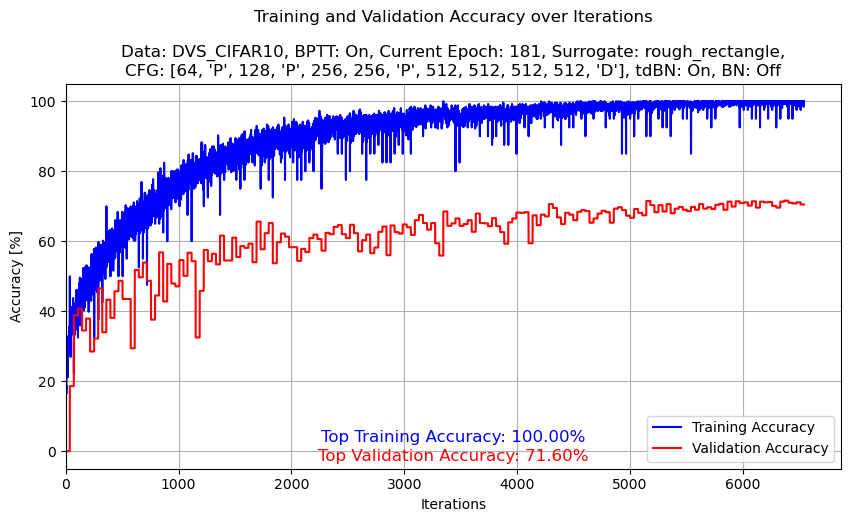

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename='hyperparameters.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
train_acc_file_name = f'result_save/{base_name}_train_acc_array.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters.json'

### if you want to just see most recent train and val acc###########################
train_acc_file_name = 'result_save/train_acc_array.npy'
val_acc_file_name = 'result_save/val_acc_now_array.npy'
hyperparameters_file_name = 'result_save/hyperparameters.json'

loaded_train_acc_array = np.load(train_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_train_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_train_acc_array, loaded_val_acc_array)
top_train_acc = hyperparameters['top_train_acc_one_iter']
top_val_acc = hyperparameters['top_val_acc']
which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_train_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_train_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {100*top_train_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()